# Transcription with advance data preprocessing and augmentation

### Prep for device config(device type = arm mac sillicon)

In [1]:
import os 
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

import warnings
warnings.filterwarnings('ignore')

In [2]:
# mps config
import torch

device = "mps" if torch.backends.mps.is_available() else "cpu"
torch_dtype = torch.float16 if torch.backends.mps.is_available() else torch.float32

### Model Config

In [3]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small").to(device)

In [4]:
# included in the training
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []
# to use gradient checkpointing
model.config.use_cache = False

### Load Dataset

#### Split Into train, test, and validation

In [5]:
from datasets import  DatasetDict, load_dataset

ds = DatasetDict()

ds = load_dataset("PolyAI/minds14", "de-DE")

train_testvalid = ds['train'].train_test_split(test_size=0.2)
# Split the 10% test + valid in half test, half valid
test_valid = train_testvalid['test'].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
ds = DatasetDict({
    'train': train_testvalid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']})
ds

DatasetDict({
    train: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 488
    })
    test: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 62
    })
    valid: Dataset({
        features: ['path', 'audio', 'transcription', 'english_transcription', 'intent_class', 'lang_id'],
        num_rows: 61
    })
})

#### Assigning new dataset for validation

In [6]:
ds2 = ds

#### Adjust frequency and Normalization

In [7]:
from datasets import Audio, DatasetDict, concatenate_datasets

AUDIO_COLUMN_NAME = "audio"
TEXT_COLUMN_NAME = "transcription"


def normalize_dataset(ds, audio_column_name=None, text_column_name=None):
    if audio_column_name is not None and audio_column_name != AUDIO_COLUMN_NAME:
        ds = ds.rename_column(audio_column_name, AUDIO_COLUMN_NAME)
    if text_column_name is not None and text_column_name != TEXT_COLUMN_NAME:
        ds = ds.rename_column(text_column_name, TEXT_COLUMN_NAME)
    # resample to the same sampling rate
    ds = ds.cast_column("audio", Audio(sampling_rate=16_000))
    # normalise columns to ["audio", "sentence"]
    ds = ds.remove_columns(set(ds.features.keys()) - set([AUDIO_COLUMN_NAME, TEXT_COLUMN_NAME]))
    return ds

raw_datasets = DatasetDict()

ds['train'] = normalize_dataset(ds['train'])
ds['test'] = normalize_dataset(ds['test'])
ds['valid'] = normalize_dataset(ds['valid'])

#### Augmentation in data train 

In [8]:
from audiomentations import (
    AddBackgroundNoise,
    AddGaussianNoise,
    Compose,
    Gain,
    OneOf,
    PitchShift,
    PolarityInversion,
    TimeStretch,
)

BASE_PATH = "./MInDS-14/audio"

# define augmentation
augmentation = Compose(
    [
        TimeStretch(min_rate=0.9, max_rate=1.1, p=0.2, leave_length_unchanged=False),
        Gain(min_gain_in_db=-6, max_gain_in_db=6, p=0.1),
        PitchShift(min_semitones=-4, max_semitones=4, p=0.2),
        OneOf(
            [
                AddBackgroundNoise(sounds_path=BASE_PATH, min_snr_in_db=1.0, max_snr_in_db=5.0, noise_transform=PolarityInversion(), p=1.0),
                AddGaussianNoise(min_amplitude=0.005, max_amplitude=0.015, p=1.0),
            ],
            p=0.2,
        ),
    ]
)


def augment_dataset(batch):
    # load and (possibly) resample audio data to 16kHz
    sample = batch[AUDIO_COLUMN_NAME]

    # apply augmentation
    augmented_waveform = augmentation(sample["array"], sample_rate=sample["sampling_rate"])
    batch[AUDIO_COLUMN_NAME]["array"] = augmented_waveform
    return batch

#### Check the length 1st!

In [9]:
ds['train']

Dataset({
    features: ['audio', 'transcription'],
    num_rows: 488
})

#### Agument and Add into existing(now we have 976 instead 488 train data!)

In [10]:
# augment training data
augmented_ds = ds["train"].map(
    augment_dataset, num_proc=4, desc="augment train dataset"
)

# combine
ds["train"] = concatenate_datasets([ds["train"], augmented_ds])
ds["train"] = ds["train"].shuffle(seed=10)

augment train dataset (num_proc=4): 100%|██████████| 488/488 [00:12<00:00, 37.84 examples/s] 


In [11]:
ds['train']

Dataset({
    features: ['audio', 'transcription'],
    num_rows: 976
})

### Prepare dataset!

In [12]:
from transformers.models.whisper.english_normalizer import BasicTextNormalizer ## Basic Text normalizer is multilingual
 
normalizer = BasicTextNormalizer()

In [13]:
from transformers import WhisperProcessor, WhisperFeatureExtractor, WhisperTokenizer

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="german", task="transcribe")
feature_extractor = WhisperFeatureExtractor.from_pretrained("openai/whisper-small")
tokenizer = WhisperTokenizer.from_pretrained("openai/whisper-small", language="german", task="transcribe")

In [14]:
do_normalize_text = True


def prepare_dataset(batch):
    # load
    audio = batch[AUDIO_COLUMN_NAME]
    # compute log-Mel input features from input audio array
    batch["input_features"] = processor.feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]
    # compute input length of audio sample in seconds
    batch["input_length"] = len(audio["array"]) / audio["sampling_rate"]

    # process targets
    input_str = normalizer(batch[TEXT_COLUMN_NAME]).strip() if do_normalize_text else batch[TEXT_COLUMN_NAME]
    # encode target text to label ids
    batch["labels"] = processor.tokenizer(input_str).input_ids

    return batch

In [15]:
vectorized_datasets = ds.map(
    prepare_dataset,
    num_proc=4,
    remove_columns=next(iter(ds.values())).column_names,
    desc="preprocess dataset",
)

preprocess dataset (num_proc=4): 100%|██████████| 61/61 [00:00<00:00, 82.99 examples/s]


#### Filter dataset by input length for get balance distribution

In [16]:
max_input_length = 30
min_input_length = 0


def is_audio_in_length_range(length):
    return length > min_input_length and length < max_input_length

In [17]:
vectorized_datasets = vectorized_datasets.filter(
    is_audio_in_length_range, num_proc=4, input_columns=["input_length"]
)

Filter (num_proc=4): 100%|██████████| 61/61 [00:00<00:00, 570.28 examples/s]


In [18]:
max_label_length = model.config.max_length


def is_labels_in_length_range(labels):
    return len(labels) < max_label_length

In [19]:
vectorized_datasets = vectorized_datasets.filter(
    is_labels_in_length_range, num_proc=4, input_columns=["labels"]
)

Filter (num_proc=4): 100%|██████████| 59/59 [00:00<00:00, 675.46 examples/s]


### Initialize Data Colator

In [20]:
from dataclasses import dataclass
from typing import Any, Dict, List, Union

import torch


@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        # convert to tensors
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad label ids to the max length in the batch
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.processor.tokenizer.bos_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

In [21]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

### Define Metrics (WER)

In [22]:
import evaluate

metric = evaluate.load("wer")

In [23]:
# evaluate with the 'normalized' WER
do_normalize_eval = True


def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    if do_normalize_eval:
        pred_str = [normalizer(pred) for pred in pred_str]
        # perhaps already normalised
        label_str = [normalizer(label) for label in label_str]
        # filtering step to only evaluate the samples that correspond to non-zero references
        pred_str = [pred_str[i] for i in range(len(pred_str)) if len(label_str[i]) > 0]
        label_str = [label_str[i] for i in range(len(label_str)) if len(label_str[i]) > 0]

    wer = metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Training args & Phase

In [24]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir="./whisper-small-ger-lr6.25-adv",
    per_device_train_batch_size=8, 
    per_device_eval_batch_size=8, 
    gradient_accumulation_steps=4,
    warmup_steps=4,
    max_steps=122,
    learning_rate=6.25e-6, 
    weight_decay=0.01, 
    gradient_checkpointing=True, 
    predict_with_generate=True, 
    generation_max_length=225, 
    logging_steps=8, 
    evaluation_strategy="steps",
    eval_steps=8,
    save_strategy="steps", 
    save_steps=8,
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
)


In [25]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=vectorized_datasets["train"],
    eval_dataset=vectorized_datasets["valid"],
    tokenizer=processor,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [26]:
trainer.train()

  7%|▋         | 8/122 [03:15<48:13, 25.38s/it]

{'loss': 2.983, 'grad_norm': 16.955373764038086, 'learning_rate': 6.038135593220339e-06, 'epoch': 0.26}


Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token.As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
                                               
  7%|▋         | 8/122 [04:22<48:13, 25.38s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation par

{'eval_loss': 2.211230754852295, 'eval_wer': 0.17956349206349206, 'eval_runtime': 67.7924, 'eval_samples_per_second': 0.87, 'eval_steps_per_second': 0.118, 'epoch': 0.26}


 13%|█▎        | 16/122 [07:41<45:14, 25.61s/it]  

{'loss': 1.9228, 'grad_norm': 15.038456916809082, 'learning_rate': 5.614406779661018e-06, 'epoch': 0.52}


                                                
 13%|█▎        | 16/122 [09:59<45:14, 25.61s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 1.5825867652893066, 'eval_wer': 1.0952380952380953, 'eval_runtime': 137.5801, 'eval_samples_per_second': 0.429, 'eval_steps_per_second': 0.058, 'epoch': 0.52}


 20%|█▉        | 24/122 [13:19<44:24, 27.19s/it]  

{'loss': 1.3936, 'grad_norm': 11.334648132324219, 'learning_rate': 5.190677966101695e-06, 'epoch': 0.79}


                                                
 20%|█▉        | 24/122 [15:41<44:24, 27.19s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 1.0462669134140015, 'eval_wer': 1.1845238095238095, 'eval_runtime': 142.1265, 'eval_samples_per_second': 0.415, 'eval_steps_per_second': 0.056, 'epoch': 0.79}


 26%|██▌       | 32/122 [18:50<40:16, 26.85s/it]  

{'loss': 0.9704, 'grad_norm': 9.35204029083252, 'learning_rate': 4.766949152542373e-06, 'epoch': 1.05}


                                                
 26%|██▌       | 32/122 [22:03<40:16, 26.85s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.9536905288696289, 'eval_wer': 2.3660714285714284, 'eval_runtime': 193.6582, 'eval_samples_per_second': 0.305, 'eval_steps_per_second': 0.041, 'epoch': 1.05}


 33%|███▎      | 40/122 [25:17<38:54, 28.47s/it]  

{'loss': 0.8859, 'grad_norm': 9.82310676574707, 'learning_rate': 4.343220338983051e-06, 'epoch': 1.31}


                                                
 33%|███▎      | 40/122 [28:21<38:54, 28.47s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.9046236276626587, 'eval_wer': 2.453373015873016, 'eval_runtime': 183.436, 'eval_samples_per_second': 0.322, 'eval_steps_per_second': 0.044, 'epoch': 1.31}


 39%|███▉      | 48/122 [31:34<35:08, 28.49s/it]  

{'loss': 0.7572, 'grad_norm': 8.358237266540527, 'learning_rate': 3.919491525423729e-06, 'epoch': 1.57}


                                                
 39%|███▉      | 48/122 [34:37<35:08, 28.49s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.86468905210495, 'eval_wer': 2.427579365079365, 'eval_runtime': 183.2126, 'eval_samples_per_second': 0.322, 'eval_steps_per_second': 0.044, 'epoch': 1.57}


 46%|████▌     | 56/122 [37:50<31:18, 28.46s/it]  

{'loss': 0.7469, 'grad_norm': 10.324573516845703, 'learning_rate': 3.495762711864407e-06, 'epoch': 1.84}


                                                
 46%|████▌     | 56/122 [41:05<31:18, 28.46s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.8293108940124512, 'eval_wer': 2.7281746031746033, 'eval_runtime': 195.1305, 'eval_samples_per_second': 0.302, 'eval_steps_per_second': 0.041, 'epoch': 1.84}


 52%|█████▏    | 64/122 [44:16<27:40, 28.63s/it]  

{'loss': 0.6778, 'grad_norm': 7.780063629150391, 'learning_rate': 3.072033898305085e-06, 'epoch': 2.1}


                                                
 52%|█████▏    | 64/122 [47:31<27:40, 28.63s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.8081901669502258, 'eval_wer': 2.818452380952381, 'eval_runtime': 195.1293, 'eval_samples_per_second': 0.302, 'eval_steps_per_second': 0.041, 'epoch': 2.1}


 59%|█████▉    | 72/122 [50:43<23:50, 28.61s/it]  

{'loss': 0.5932, 'grad_norm': 8.67540454864502, 'learning_rate': 2.648305084745763e-06, 'epoch': 2.36}


                                                
 59%|█████▉    | 72/122 [53:58<23:50, 28.61s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.7917385101318359, 'eval_wer': 2.8680555555555554, 'eval_runtime': 195.1961, 'eval_samples_per_second': 0.302, 'eval_steps_per_second': 0.041, 'epoch': 2.36}


 66%|██████▌   | 80/122 [57:09<19:55, 28.47s/it]  

{'loss': 0.5879, 'grad_norm': 8.530070304870605, 'learning_rate': 2.2245762711864407e-06, 'epoch': 2.62}


                                                
 66%|██████▌   | 80/122 [1:00:24<19:55, 28.47s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.775465726852417, 'eval_wer': 2.7668650793650795, 'eval_runtime': 195.4123, 'eval_samples_per_second': 0.302, 'eval_steps_per_second': 0.041, 'epoch': 2.62}


 72%|███████▏  | 88/122 [1:03:34<16:08, 28.49s/it]

{'loss': 0.5968, 'grad_norm': 9.402825355529785, 'learning_rate': 1.8008474576271187e-06, 'epoch': 2.89}


                                                  
 72%|███████▏  | 88/122 [1:06:50<16:08, 28.49s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.762309193611145, 'eval_wer': 2.640873015873016, 'eval_runtime': 195.7048, 'eval_samples_per_second': 0.301, 'eval_steps_per_second': 0.041, 'epoch': 2.89}


 79%|███████▊  | 96/122 [1:09:58<12:10, 28.10s/it]

{'loss': 0.5491, 'grad_norm': 9.611059188842773, 'learning_rate': 1.3771186440677967e-06, 'epoch': 3.15}


                                                  
 79%|███████▊  | 96/122 [1:13:13<12:10, 28.10s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.7546915411949158, 'eval_wer': 2.507936507936508, 'eval_runtime': 195.1232, 'eval_samples_per_second': 0.302, 'eval_steps_per_second': 0.041, 'epoch': 3.15}


 85%|████████▌ | 104/122 [1:16:25<08:34, 28.60s/it]

{'loss': 0.4959, 'grad_norm': 7.619028091430664, 'learning_rate': 9.533898305084747e-07, 'epoch': 3.41}


                                                   
 85%|████████▌ | 104/122 [1:19:40<08:34, 28.60s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.7489808201789856, 'eval_wer': 2.419642857142857, 'eval_runtime': 194.9033, 'eval_samples_per_second': 0.303, 'eval_steps_per_second': 0.041, 'epoch': 3.41}


 92%|█████████▏| 112/122 [1:22:51<04:43, 28.34s/it]

{'loss': 0.4853, 'grad_norm': 7.708927631378174, 'learning_rate': 5.296610169491525e-07, 'epoch': 3.67}


                                                   
 92%|█████████▏| 112/122 [1:26:05<04:43, 28.34s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.743336021900177, 'eval_wer': 2.4057539682539684, 'eval_runtime': 194.2398, 'eval_samples_per_second': 0.304, 'eval_steps_per_second': 0.041, 'epoch': 3.67}


 98%|█████████▊| 120/122 [1:29:19<00:57, 28.86s/it]

{'loss': 0.5301, 'grad_norm': 8.639152526855469, 'learning_rate': 1.0593220338983051e-07, 'epoch': 3.93}


                                                   
 98%|█████████▊| 120/122 [1:32:34<00:57, 28.86s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


{'eval_loss': 0.7405820488929749, 'eval_wer': 2.3978174603174605, 'eval_runtime': 195.1298, 'eval_samples_per_second': 0.302, 'eval_steps_per_second': 0.041, 'epoch': 3.93}


100%|██████████| 122/122 [1:33:24<00:00, 67.50s/it]Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}
There were missing keys in the checkpoint model loaded: ['proj_out.weight'].
100%|██████████| 122/122 [1:33:29<00:00, 45.98s/it]

{'train_runtime': 5609.8744, 'train_samples_per_second': 0.696, 'train_steps_per_second': 0.022, 'train_loss': 0.9373875670745725, 'epoch': 4.0}


TrainOutput(global_step=122, training_loss=0.9373875670745725, metrics={'train_runtime': 5609.8744, 'train_samples_per_second': 0.696, 'train_steps_per_second': 0.022, 'total_flos': 1.12202003644416e+18, 'train_loss': 0.9373875670745725, 'epoch': 4.0})

### Save model for inference!

In [53]:
model.save_pretrained(training_args.output_dir)
processor.save_pretrained(training_args.output_dir)

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 448, 'suppress_tokens': [], 'begin_suppress_tokens': [220, 50257]}


[]

### Evaluate and Inference

In [28]:
import pandas as pd
trainer_history = pd.DataFrame(trainer.state.log_history)
trainer_history.groupby('step').first().reset_index()
trainer_history

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_wer,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.9830,16.955374,6.038136e-06,0.262295,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.262295,8,2.211231,0.179563,67.7924,0.870,0.118,NaN,NaN,NaN,NaN,NaN
2,1.9228,15.038457,5.614407e-06,0.524590,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,0.524590,16,1.582587,1.095238,137.5801,0.429,0.058,NaN,NaN,NaN,NaN,NaN
4,1.3936,11.334648,5.190678e-06,0.786885,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,0.786885,24,1.046267,1.184524,142.1265,0.415,0.056,NaN,NaN,NaN,NaN,NaN
6,0.9704,9.352040,4.766949e-06,1.049180,32,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,1.049180,32,0.953691,2.366071,193.6582,0.305,0.041,NaN,NaN,NaN,NaN,NaN
8,0.8859,9.823107,4.343220e-06,1.311475,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,1.311475,40,0.904624,2.453373,183.4360,0.322,0.044,NaN,NaN,NaN,NaN,NaN


### Evaluation
Lowest Wer scores actualy at the early phase of training and continue rose up until step 80 and start declining! WER: 0.17%

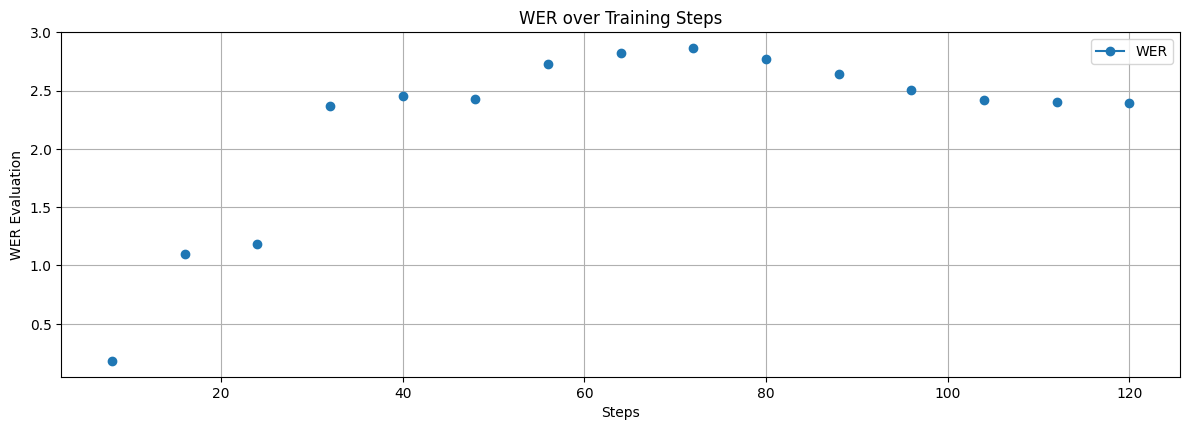

In [29]:
import matplotlib.pyplot as plt

# Plot WER over training steps
plt.figure(figsize=(12, 8))

# Plot WER
plt.subplot(2, 1, 1)
plt.plot(trainer_history['step'], trainer_history['eval_wer'], marker='o', label='WER')
plt.title("WER over Training Steps")
plt.xlabel("Steps")
plt.ylabel("WER Evaluation")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Inference

In [55]:
import time
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# Define the path to the model checkpoint
model_path = "./whisper-small-ger-lr6.25-adv/checkpoint-8"

# Load the best fine-tuned model
try:
    model = WhisperForConditionalGeneration.from_pretrained(model_path).to(device)
    processor = WhisperProcessor.from_pretrained(model_path)
    print("Model and processor loaded successfully.")
except OSError as e:
    print(f"Error loading model or processor: {e}")

# Inference function
# Inference function with language token
def transcribe(audio):
    input_features = processor(audio["array"], sampling_rate=audio["sampling_rate"], return_tensors="pt").input_features.to(device)
    forced_decoder_ids = processor.get_decoder_prompt_ids(language="de", task="transcribe")
    predicted_ids = model.generate(input_features, forced_decoder_ids=forced_decoder_ids)
    transcription = processor.batch_decode(predicted_ids, skip_special_tokens=True)
    return transcription[0]

Model and processor loaded successfully.


### Inference Result

we got 1.0117 seconds for best inference and avg wer of 0.4%. Yeay!

In [49]:
# Run inference on three samples
for i in range(3):
    sample = ds2["test"][i]
    
    start_time = time.time()
    transcription = transcribe(sample["audio"])
    end_time = time.time()
    
    inference_time = end_time - start_time
    
    print(f"Sample {i+1}:")
    print(f"Reference: {sample['transcription']}")
    print(f"Prediction: {transcription}")
    print(f"Inference time: {inference_time:.4f} seconds")
    print()

# Calculate overall WER for these three samples
wer = metric.compute(predictions=[transcribe(ds2["test"][i]["audio"]) for i in range(3)],
                     references=[ds2["test"][i]["transcription"] for i in range(3)])
print(f"WER for 3 samples: {wer}")

Sample 1:
Reference: ich würde gerne meinen aktuellen Kontostand einsehen
Prediction: ich würde gerne meinen aktuellen kontostand einzahlen
Inference time: 1.0117 seconds

Sample 2:
Reference: Hallo ich bin am Wochenende nach Warschau und habe meine Bank geguckt geschrieben gewechselt und wollte nur sicher gehen dass ich meine Kreditkarte dann auch da benutzen kann
Prediction: hallo ich bin ein wochen um nach wasch auf und habe meine bankkreditkarte zu ihnen gewechselt und wollte mir sichergehen dass ich meine kreditkarte dann auch da benutzen kann
Inference time: 2.7010 seconds

Sample 3:
Reference: Hallo ich habe eine Frage wo kann ich denn überall Geld einzahlen ich habe mal gesehen was kann das in den Supermärkten eventuell die ausgewiesen gibt's da noch mehr stellen
Prediction: hallo ich habe eine frage wo kann ich denn überall geld einzahlen ich habe mal gesehen man kann das in den supermärkten und baumärkten eventuell die ausgewählten einzahlen gibt es da noch mehr stellen
Infer

### Little Bit of Demo for Spice it up
ps try to speak in german and let the fine tune model transcribe!

In [51]:
import sounddevice as sd
import numpy as np

# Function to record audio from the microphone
def record_audio(duration, sample_rate=16000):
    print("Recording...")
    audio = sd.rec(int(duration * sample_rate), samplerate=sample_rate, channels=1, dtype='float32')
    sd.wait()  # Wait until the recording is finished
    print("Recording finished.")
    audio = np.squeeze(audio)  # Remove single-dimensional entries
    return {"array": audio, "sampling_rate": sample_rate}

# Record audio from the microphone
duration = 10  # Record for 5 seconds
audio = record_audio(duration)

# Transcribe the recorded audio
transcription = transcribe(audio)
print("Transcription:", transcription)

Recording...
Recording finished.
Transcription: hallo mein name ist sabir und ich studiere jes kundschiller intelligence
